In [34]:
import keras
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

<h3>Cats vs Dogs</h3>
<p> 
We will be doing the <a href='https://www.kaggle.com/c/dogs-vs-cats'>Cats vs Dogs kaggle data challange</a>. With just a few lines of code and about 20 minutes of work, we can use Transfer Learning and the concept of Embedding to build a model that would have placed us in the top 20 of all challange entries circa 2013.</p>
<p>To keep things simple I have copied the code I used to read the dateset images in and resize them to shape (224 x 224 x 3) (height,width,RGB-color) and save to the arrays to numpy matrices. Note this is not a particularly good thing to do it with image data, it just makes the preprocessing simpler and allows us to focus on model basics.
</p>

In [87]:
import glob
import PIL
import numpy as np
from sklearn import model_selection

p='/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/data/train/'
all_files = glob.glob(p+'*')

reprocess = False

if reprocess:
    # First resize and convert images to numpy array
    y   = np.empty((len(all_files)), np.int)
    x   = np.empty( (len(all_files),224,224,3), np.uint8 )

    for i,ff in enumerate(all_files):
        flg = 0 if 'cat' in ff.split('/')[-1] else 1

        y[i] = flg
        x[i] = np.array(PIL.Image.open(ff).resize((224,224)))


    x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=.2,stratify=y)
    del x
    
    np.savez_compressed('/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/dset.npz', 
                         x_train = x_train, 
                         x_test  = x_test, 
                         y_train = np.atleast_2d(y_train).T,
                         y_test  = np.atleast_2d(y_test).T
                       )

else:
    d=np.load('/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/dset.npz')
    x_train = d['x_train'] 
    x_test  = d['x_test'] 
    y_train = d['y_train']
    y_test  = d['y_test']

<p>First lets select some random images and see what we will be working with!</p>

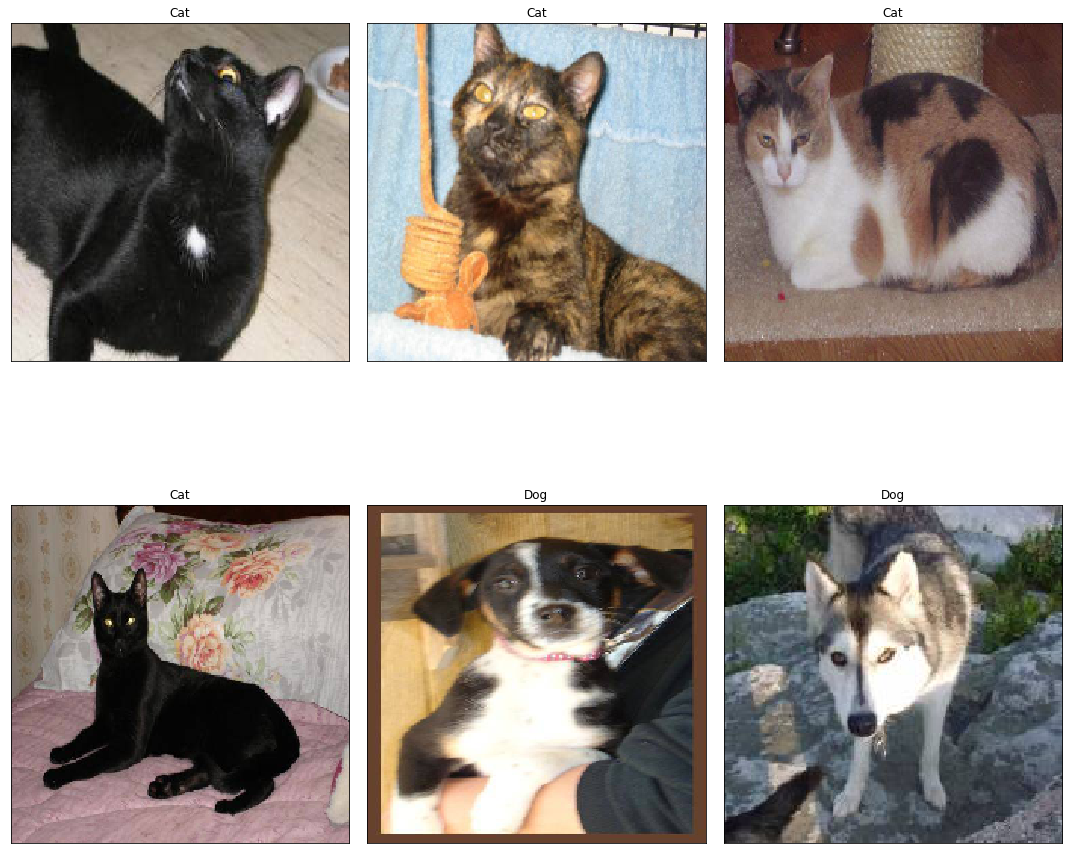

In [32]:
plt.figure(figsize=(15,15))
for i,idx in enumerate(np.random.randint(0,y_test.shape[0],6)):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[idx])
    plt.title('Dog' if y_test[idx] else 'Cat')
    plt.xticks([]); plt.yticks([])

plt.tight_layout()

<h3>VGG16</h3>
<p><a href='https://arxiv.org/abs/1409.1556'>VGG16</a> is the name of a Neural Network Architecture for image recognition that won second place in the <a href='http://www.image-net.org/challenges/LSVRC/'>ImageNet  ILSVRC-2014 competition</a>. It is no longer among the the best preforming architecture for image recognition but it is among the simplest to tinker with and consequently it is still widely used today.</p>
<p>Training an architecture like VGG16 from scratch is no trivial task, but fortunately the optimal weights for doing image classification with VGG16 are open source! Within a couple lines of code/a few minutes we can load up the VGG16 model that won imagenet 2014 and use it to do anything we want! This is the basis of transfer learning. We will use the feature extraction strategy learned by VGG16 on one set of images, and apply (transfer) them to generate features on a completely different set of images saving months of work and likley many thousands of dollars!</p>
<p>Because it is so commonly used keras makes it easy to import the vgg16 along with its weights. See  documentation for <b>keras.applications.VGG16</b> for details.</p>

In [3]:
keras.applications.VGG16??

In [36]:
x=keras.layers.Input((224,224,3))
vgg16 = keras.applications.VGG16( 
                                 input_tensor=x,
                                 )
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

<p>The imagnet weights assume all image inputs will have zero mean, and be orderd BGR instead of RGB like our dog & cat datset. Thus before passing our images into VGG we will want to 1) nomalize our data using the mean RBG values of the imagenet dataset and 2) reorder our color channels. We can create a simple custom layer called a Lambda layer that will apply this precoessing on the fly by keras!</p>

In [37]:
#image net mean BGR
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))

#Custom layer substracts mean & reorders the color (last) dimension
vgg_norm = keras.layers.Lambda(lambda x: x[:,:,::-1]-vgg_mean, 
                               output_shape=lambda x: x,
                              name='VGG_Norm')

<p>The imagenet competition our VGG model was optimized for sought to classify images into one of a 1,000 different catagories. Consiquently the VGG16 model above generates a (1x1000) output vector for each input. (See model summary above). Our goal here is to not classify the images (yet) but to use the convoltional stages of vgg to generate a consice description of our image.</p>
<p>Lets use the model above to build a new model that will:</p>
    <ol><li>Apply our custum vgg_norm layer to the model input.</li>
        <li>Pass the now normzlied inputs through the convolutional filters of VGG</li>
        <li>Take the ouput from the convolutional filters of vgg and perform GlobalAveragePooling2D on it to create 1-D vector summerizing each image.</li>
    </ol>
    
To do this we will need to select all but last 5 layers of the vgg model above. The model.layers member variable is a list of all the layers/weights in our model. Try to select all but last 5 layers of vgg above and pass your normalized inputs through this sequence of layers. To cap it all off, apply the GlobalAveragePooling2D layer and generate a new model incorperating everything we want!
   </p>

In [38]:
#Pass input through our custom normalization layer
input_image=keras.layers.Input((224,224,3))
x=vgg_norm(input_image)

#Throw away the last 5 layers of vgg and pass x through the remaining layers
#Set each vgg layer to trainable=False so keras will not change those weights!
keep_layers = [l for l in vgg16.layers[0:len(vgg16.layers)-5]]
for l in keep_layers:
    l.trainable=False
    x = l(x)
    
#Now add on the new layer
x = keras.layers.GlobalAveragePooling2D()(x)

In [39]:
#Create our new vgg model!
my_vgg = keras.models.Model(inputs=input_image, outputs=x)
my_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
VGG_Norm (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
__________

<p>Running 5k images through vgg16 took ~36 minutes on my laptop cpu. You can run it if you like on both the test & training set data but I would rather not.</p>

In [34]:
out = my_vgg.predict(x_test,verbose=1,batch_size=32)

5000/5000 [==============================] - 2200s 440ms/step


<p>Fortunatly we have a gpu on odin, and running the same computation there took me ~30 seconds! For the sake of sanity/expeedency I have taken the liberty of precomupting the outputs for each image in our dataset. You can download the (1x512) outputs for each image in the numpy archive image_embedings.npz <a href='https://drive.google.com/drive/folders/1fe5uNIqvJXO8HZZ6E8Ai5JEf4hoWRCcE?usp=sharing'> located here</a>. So lets just download these precumputed values as use them in subsiquent steps.</p> 

In [88]:
data = np.load('/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/image_embedings.npz')

x_train_em = data['x_train']
#y_train = data['y_train']

x_test_em = data['x_test']
#y_test = data['y_test']

<p>
To build a classifyer on-top of these predictions we need to only apply:
<ol>
    <li><b>keras.layers.Input</b>   -- to stub out our input data</li>
    <li><b>keras.layers.Dropout</b> -- to prevent overfitting.</li>
    <li><b>keras.layers.Dense</b>   -- to transform our features into a binary 0/1 (cat/dog) flag!</li>
</ol>
Honestly a (pick you favorate package in sklearn) would probably work just as well here, but lets get the practice building models in keras!
</p>

In [89]:
inp = keras.layers.Input((512,))
x = keras.layers.Dropout(0.5)(inp)
out = keras.layers.Dense(1,activation=keras.activations.sigmoid)(x)
model = keras.models.Model(inp,out)
model.compile(keras.optimizers.Adam(), keras.losses.binary_crossentropy,metrics=['accuracy'])
model.fit( x=x_train_em, y=y_train,
           batch_size=32, epochs=2, 
           validation_data=(x_test_em,y_test),
           verbose=1
          )

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 1s 60us/step - loss: 0.7029 - acc: 0.8638 - val_loss: 0.0918 - val_acc: 0.9720
Epoch 2/2
20000/20000 [==============================] - 1s 37us/step - loss: 0.2075 - acc: 0.9427 - val_loss: 0.0736 - val_acc: 0.9746


In [90]:
y_pred = model.predict(x_test_em)

y_pred_r = np.round(y_pred,0)

In [107]:
wrong_labels = np.argwhere(y_pred_r.flatten() != y_test.flatten()).flatten()

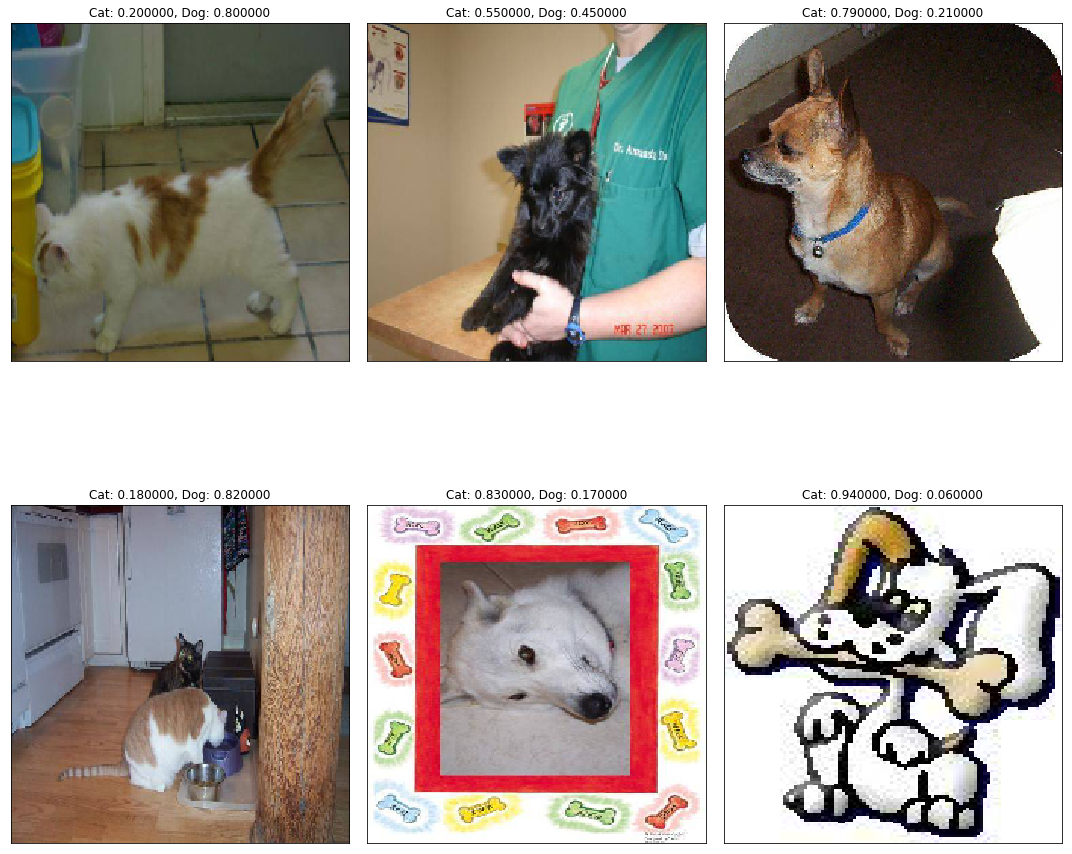

In [111]:
plt.figure(figsize=(15,15))
for i,idx in enumerate(np.random.choice(wrong_labels,6,replace=False)):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[idx])
    plt.title("Cat: %f, Dog: %f"%(np.round(1-y_pred[idx],2),np.round(y_pred[idx],2)))
    plt.xticks([]); plt.yticks([])

plt.tight_layout()

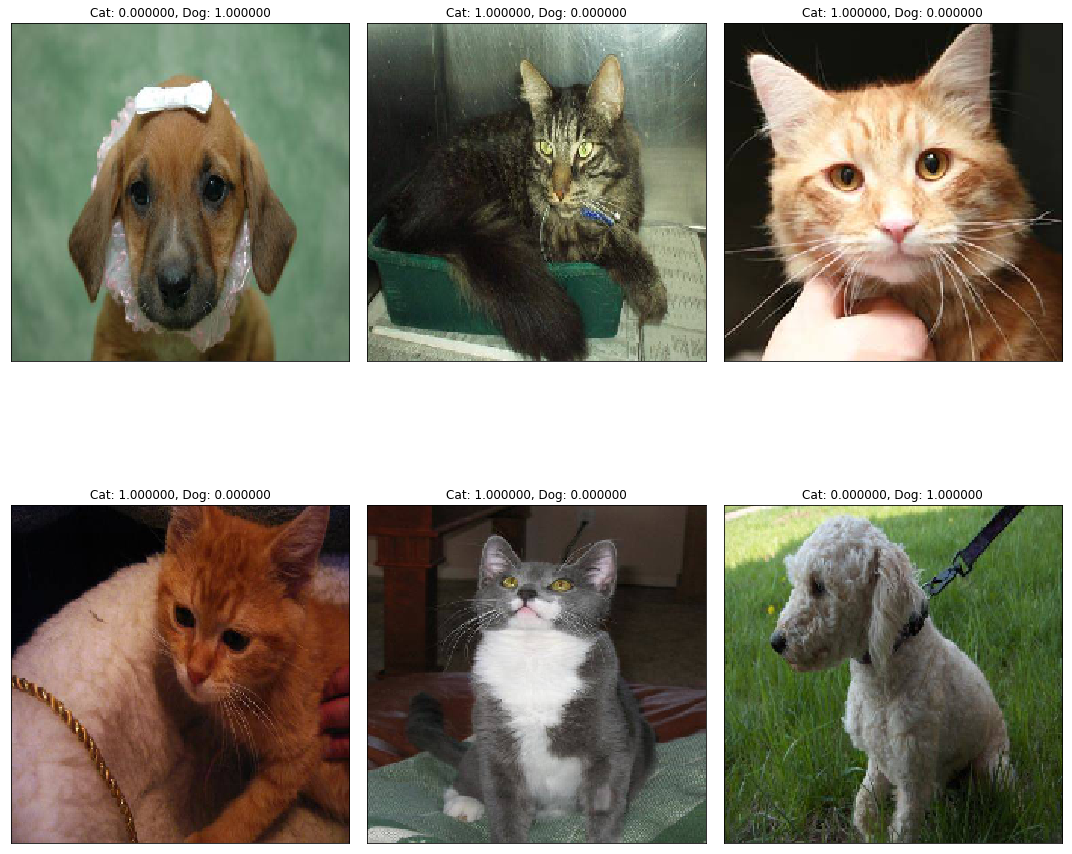

In [113]:
correct_labels = np.argwhere(y_pred_r.flatten() == y_test.flatten()).flatten()
plt.figure(figsize=(15,15))
for i,idx in enumerate(np.random.choice(correct_labels,6,replace=False)):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[idx])
    plt.title("Cat: %f, Dog: %f"%(np.round(1-y_pred[idx],2),np.round(y_pred[idx],2)))
    plt.xticks([]); plt.yticks([])

plt.tight_layout()